# Offline Mode Interactive Plots

Interactive plots from datamapplot can be saved as HTML files for easy sharing. One catch is that the files refer to Javascript dependencies and fonts that are provided by CDNs. This means that the generated HTML files will not work when offline, running on air-gapped networks, or behind strict firewalls. This can be problematic for users stuck in those situations. To remedy this, Datamapplot has support for an "offline mode" that embeds the relevant javascript and fonts directly into the HTML so the resulting output is fully independent and can be viewed offline or behind firewalls.

Of course to do this the relevant Javascript and fonts need to be collected to be embedded; these code and font files are stored in an **offline cache**. To make the collection of this cache easier, a command-line tool is provided: ``dmp_offline_cache``. This will allow you to download and store the relevant data while connected to the internet, and then make use of the cached files for offline mode work thereafter.

## Collecting the cache

Let's have a look at the help for `dmp_offline_cache`:

In [1]:
!dmp_offline_cache --help

usage: dmp_offline_cache [-h] [--js_urls JS_URLS [JS_URLS ...]]
                         [--font_names FONT_NAMES [FONT_NAMES ...]]
                         [--refresh] [--no-refresh]
                         [--js_cache_file JS_CACHE_FILE]
                         [--font_cache_file FONT_CACHE_FILE] [--import IMPORT]
                         [--export EXPORT] [-y]

Cache JS and font files for offline mode

options:
  -h, --help            show this help message and exit
  --js_urls JS_URLS [JS_URLS ...]
                        CDN URLs to fetch and cache js from
  --font_names FONT_NAMES [FONT_NAMES ...]
                        Names of google font fonts to cache
  --refresh             Force refresh cached files from Internet repositories.
                        This is the default.
  --no-refresh          Omit refreshing cached files from Internet
                        repositories.
  --js_cache_file JS_CACHE_FILE
                        Path to save JS cache file
  --font_cache_

You can specify which Javascript modules you wish to collect, which fonts you wish to collect, and file paths of where to store the cache files. If these aren't specified, sane default choices will be used that should cover most basic cases. There is also a ``--refresh`` option that will download the latest versions of javascript libraries and fonts to make sure you are up to date.

We can see what javascript and fonts will be collected, and where they will be cached by inspecting variables in the ``offline_mode_caching`` module:

In [2]:
import datamapplot.offline_mode_caching

The Javascriupt libraries cached by default are stored in the ``DEFAULT_URLS`` variable:

In [3]:
datamapplot.offline_mode_caching.DEFAULT_URLS

['https://unpkg.com/deck.gl@latest/dist.min.js',
 'https://unpkg.com/apache-arrow@latest/Arrow.es2015.min.js',
 'https://unpkg.com/d3@latest/dist/d3.min.js',
 'https://unpkg.com/jquery@3.7.1/dist/jquery.min.js',
 'https://unpkg.com/d3-cloud@1.2.7/build/d3.layout.cloud.js']

A selection of fonts that are good choices for interactive datamapplots are stored in ``BASE_FONTS``:

In [4]:
datamapplot.offline_mode_caching.BASE_FONTS

['Roboto',
 'Open Sans',
 'Montserrat',
 'Oswald',
 'Merriweather',
 'Merriweather Sans',
 'Playfair Display',
 'Playfair Display SC',
 'Roboto Condensed',
 'Ubuntu',
 'Cinzel',
 'Cormorant',
 'Cormorant SC',
 'Marcellus',
 'Marcellus SC',
 'Anton',
 'Anton SC',
 'Arsenal',
 'Arsenal SC',
 'Baskervville',
 'Baskervville SC',
 'Lora',
 'Quicksand',
 'Bebas Neue']

Finally you can see where the cache files will be stored by checking ``DEFAULT_CACHE_FILES``. Note that this is operating system dependent, so the files may have different locations if you are running on a Mac or Windows.

In [5]:
datamapplot.offline_mode_caching.DEFAULT_CACHE_FILES

{'javascript': '/home/bjhamel/.local/share/datamapplot/datamapplot_js_encoded.json',
 'fonts': '/home/bjhamel/.local/share/datamapplot/datamapplot_fonts_encoded.json'}

## Producing a data map to use offline

Now let's see an example of this in action. We will import datamapplot and load up some data suitable for making an interactive plot.

In [6]:
import datamapplot
import numpy as np
import requests
import io

base_url = "https://github.com/TutteInstitute/datamapplot"
data_map_file = requests.get(f"{base_url}/raw/main/examples/arxiv_ml_data_map.npy")
arxivml_data_map = np.load(io.BytesIO(data_map_file.content))
arxivml_label_layers = []
for layer_num in range(5):
    label_file = requests.get(
        f"{base_url}/raw/interactive/examples/arxiv_ml_layer{layer_num}_cluster_labels.npy"
    )
    arxivml_label_layers.append(
        np.load(io.BytesIO(label_file.content), allow_pickle=True)
    )
hover_data_file = requests.get(
    f"{base_url}/raw/interactive/examples/arxiv_ml_hover_data.npy"
)
arxiv_hover_data = np.load(io.BytesIO(hover_data_file.content), allow_pickle=True)

Now we make a plot exactly as we normally would, but include the extra keyword argument ``offline_mode=True``. If you have stored your cache files somewhere other than the default location you can specify these via ``offline_mode_js_data_file`` and ``offline_mode_font_data_file``. It is worth noting that if you haven't run ``dmp_offline_cache`` on the command line, or the relevant files in the default location don't yet exist, they will be created for you.

<InteractiveFigure width=100% height=800>
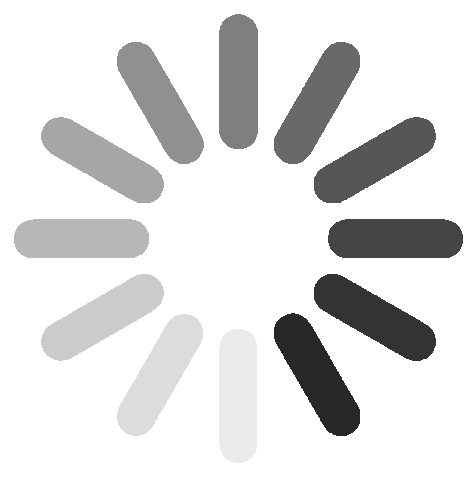

In [7]:
plot = datamapplot.create_interactive_plot(
    arxivml_data_map,
    arxivml_label_layers[0],
    arxivml_label_layers[2],
    arxivml_label_layers[4],
    hover_text=arxiv_hover_data,
    font_family="Cormorant SC",
    title="ArXiv Machine Learning Landscape",
    sub_title="A data map of papers from the Machine Learning section of ArXiv",
    logo="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/ArXiv_logo_2022.svg/512px-ArXiv_logo_2022.svg.png",
    logo_width=180,
    on_click='window.open(`http://google.com/search?q="{hover_text}"`)',
    enable_search=True,
    darkmode=True,
    offline_mode=True,
)
plot

You can now save the resulting file and have an interactive plot that works offline and behind firewalls.

In [8]:
plot.save("arxiv_ml_offline_mode.html")

## Moving one's cache around to work on a closed network

While many features of DataMapPlot work leverage one's Internet connection,
it is possible to also produce useful data maps on networks where no such connection is available.
If you bring some software on a USB stick for running ad hoc data analysis on your assistant's laptop computer during a field trip deep in the boonies,
we want to equip you to map that data _in situ_.
(That assistant can go play their Solitaire on a real deck of cards in the meantime.)

We assume that you can access a mechanism for carrying some files onto this computer bereft from the Internet.
You can then _export_ your offline cache to a Zip archive to move over to that computer:

In [9]:
!dmp_offline_cache --export my-cache.zip

from zipfile import ZipFile

with ZipFile("my-cache.zip", "r") as zf:
    for entry in zf.infolist():
        print(entry)

<ZipInfo filename='datamapplot_js_encoded.json' compress_type=deflate filemode='?rw-------' file_size=2663586 compress_size=898750>
<ZipInfo filename='datamapplot_fonts_encoded.json' compress_type=deflate filemode='?rw-------' file_size=6777893 compress_size=3405736>


This command first refreshes your cache ahead of exporting it to this Zip file.
If you think of running this export while in transit to this field trip and your Internet connection has already gone unreliable,
you can skip this refresh:

In [10]:
!dmp_offline_cache --export it-is-what-it-is.zip --no-refresh

Once this Zip archive has been transferred over the no-Internet computer,
the offline cache can be imported there:

```sh
dmp_offline_cache --import my-cache.zip
```

### Incremental cache updates

The `dmp_offline_cache` tool does not fully replace the cache when importing from an archive.
Rather, it identifies similarly named cache entries and provides an opportunity to determine which cache elements to update &mdash;
new elements are transferred without confirmation.
It first makes the user select Javascript code files to update,
and follows with the fonts.
Here is an example of such an interactive selection:

```
$ dmp_offline_cache --import my-cache.zip

These Javascript files would be replaced in cache at /home/bjhamel/.local/share/datamapplot. Select to confirm:
  1. https://unpkg.com/apache-arrow@latest/Arrow.es2015.min.js
  2. https://unpkg.com/d3-cloud@1.2.7/build/d3.layout.cloud.js
  3. https://unpkg.com/d3@latest/dist/d3.min.js
  4. https://unpkg.com/deck.gl@latest/dist.min.js
  5. https://unpkg.com/jquery@3.7.1/dist/jquery.min.js
NUMBER single item, FIRST-LAST interval, a all, ? help, . finish> 1-3 5

These Javascript files would be replaced in cache at /home/bjhamel/.local/share/datamapplot. Select to confirm:
* 1. https://unpkg.com/apache-arrow@latest/Arrow.es2015.min.js
* 2. https://unpkg.com/d3-cloud@1.2.7/build/d3.layout.cloud.js
* 3. https://unpkg.com/d3@latest/dist/d3.min.js
  4. https://unpkg.com/deck.gl@latest/dist.min.js
* 5. https://unpkg.com/jquery@3.7.1/dist/jquery.min.js
NUMBER single item, FIRST-LAST interval, a all, ? help, . finish> .

These fonts would be replaced in cache at /home/bjhamel/.local/share/datamapplot. Select to confirm:
   1. Anton
   2. Anton SC
   3. Arsenal
   4. Arsenal SC
   5. Baskervville
   6. Baskervville SC
   7. Bebas Neue
   8. Cinzel
   9. Cormorant
  10. Cormorant SC
  11. Lora
  12. Marcellus
  13. Marcellus SC
  14. Merriweather
  15. Merriweather Sans
  16. Montserrat
  17. Open Sans
  18. Oswald
  19. Playfair Display
  20. Playfair Display SC
  21. Quicksand
  22. Roboto
  23. Roboto Condensed
  24. Ubuntu
NUMBER single item, FIRST-LAST interval, a all, ? help, . finish> 2 4 6 10 20

These fonts would be replaced in cache at /home/bjhamel/.local/share/datamapplot. Select to confirm:
   1. Anton
*  2. Anton SC
   3. Arsenal
*  4. Arsenal SC
   5. Baskervville
*  6. Baskervville SC
   7. Bebas Neue
   8. Cinzel
   9. Cormorant
* 10. Cormorant SC
  11. Lora
  12. Marcellus
  13. Marcellus SC
  14. Merriweather
  15. Merriweather Sans
  16. Montserrat
  17. Open Sans
  18. Oswald
  19. Playfair Display
* 20. Playfair Display SC
  21. Quicksand
  22. Roboto
  23. Roboto Condensed
  24. Ubuntu
NUMBER single item, FIRST-LAST interval, a all, ? help, . finish> 13.
```

So in a nutshell, one types the index of any entry to update to select it;
typing it once again deselects it.
One can use the `<first>-<last>` syntax to toggle the selection for an interval of entries,
or `a` to toggle selection for all of them.
Every time one types `[Enter]`,
the selection is refreshed,
selected items being prepended with `*`.
Once the selection is satisfactory,
type `.[Enter]` to proceed with replacing the selected entries.
This simple interactive protocol can be recalled by typing `?[Enter]`:

```
These Javascript files would be replaced in cache at /home/bjhamel/.local/share/datamapplot. Select to confirm:
  1. https://unpkg.com/apache-arrow@latest/Arrow.es2015.min.js
  2. https://unpkg.com/d3-cloud@1.2.7/build/d3.layout.cloud.js
  3. https://unpkg.com/d3@latest/dist/d3.min.js
  4. https://unpkg.com/deck.gl@latest/dist.min.js
  5. https://unpkg.com/jquery@3.7.1/dist/jquery.min.js
NUMBER single item, FIRST-LAST interval, a all, ? help, . finish> ?

Type the number of an item to select it: 2

You can select an interval of items: 2-4
selects items 2, 3 and 4.

You can toggle all items: a

Selecting again an item then deselects it, whether using single number,
interval or a.

Type . to complete the selection process and go ahead with the replacements.

Type Enter to make the command happen, forcing the selection menu to refresh.

You can type multiple commands ahead of Enter: 1 3 2-4 7 .
selects items 1, 2, 4 and 7 (3 was selected, then deselected by the interval),
then proceeds.
```

And like for most programs, `[Ctrl]+C` cancels the run of the program altogether.
If one is happy with blindly updating cache entries from the archive,
one can just skip the interactive confirmation with option `--yes`:

```sh
dmp_offline_cache --import my-cache.zip --yes
```

Similarly, when `--export`ing one's cache contents to an archive that already exists,
the same replacement confirmation process takes place.
It can be bypassed using `--yes` just as well.

In [11]:
# Clean up after ourselves
from pathlib import Path

for name in ["my-cache.zip", "it-is-what-it-is.zip"]:
    Path(name).unlink(missing_ok=True)